In [165]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils.bbox_utils import bboxes_relative, convert_to_corners

In [166]:
def draw_image(img, figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')

In [167]:
bbox_annotations = np.array([
    [600, 925, 695, 1125],
    [900, 930, 965, 1085],
    [1360, 930, 1405, 1040],
    [1110, 920, 1350, 1150],
    [755, 710, 2570, 2900]
])

image shape HWC: (3024, 3024, 3)


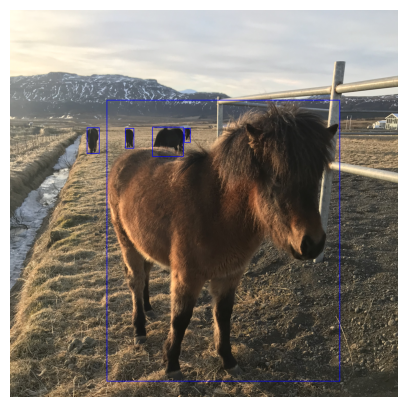

In [168]:
img = cv2.imread('assets/test_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[:img.shape[1], :, :] # crop to square
print(f"image shape HWC: {img.shape}")

color = (0, 0, 255)
test_color = (255, 0, 255)
thickness=3
for bbox in bbox_annotations:
    xmin, ymin, xmax, ymax = bbox
    annotated_image = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=color, thickness=thickness)


draw_image(annotated_image)

### Faster R-CNN Anchors
 k: maximum possible proposals ("anchors") for each location k
 - Anchors are defined by $a$ aspect ratios and $s$ scales yielding $k = a \times s$ anchors per location
 - Anchors are centered at each sliding window location where n x n yields the spatial size of the sliding window acroos the input image
 - Multi-scale Anchors as Regression References
    - Faster R-CNN aims to avoid feature pyramid or other scaling approaches at the feature level by creating "a pyramid of anchors" by creating anchors at different scales

**Create Sample Anchor Boxes**

In [169]:
target_size = annotated_image.shape[:2]
stride = 100
x = np.arange(start=stride/2, stop=target_size[0], step=stride, dtype=float)
y = np.arange(start=stride/2, stop=target_size[1], step=stride, dtype=float)

In [170]:
xv, yv = np.meshgrid((x), (y))
centers = np.stack([yv, xv], axis=-1)
wh = np.ones_like(centers) * 300 # for testing only creating single anchor per location with width == height == 3
anchors_grid = np.concatenate([centers, wh], axis=-1)
anchors = anchors_grid.reshape(anchors_grid.shape[0] * anchors_grid.shape[1], anchors_grid.shape[2])

**Visualize Sample Anchor Centers**

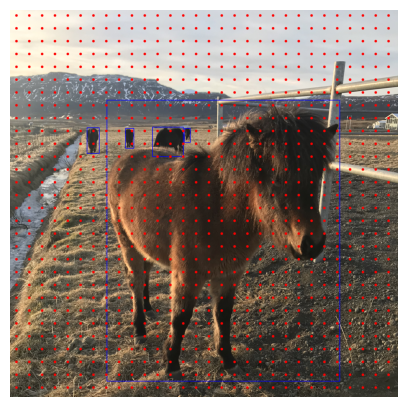

In [171]:
anchor_centers_image = cv2.resize(annotated_image, target_size)

for i, anchor in enumerate(anchors):
    x, y, w, h = anchor
    x1,y1,x2,y2 = corner_anchor.astype(int)
    anchor_centers_image = cv2.circle(anchor_centers_image, (int(x),int(y)), radius=10, color=(255, 0, 0), thickness=-1)    
    
draw_image(anchor_centers_image)

**Define and Visualize Anchors**

In [194]:
def calc_wh(base_size, scale, ar):
    base_size *= scale
    ar = ar[0]/ar[1]
    height = base_size / ar
    width = ar * base_size
    return width, height 

def create_anchors(image_size, stride=100, aspect_ratios=[[1,1], [1,2], [2,1]], scales=[0.25, 0.5, 1], base_anchor_size=128):
    x = np.arange(start=stride/2, stop=image_size[0], step=stride, dtype=float)
    y = np.arange(start=stride/2, stop=image_size[1], step=stride, dtype=float)
    xv, yv = np.meshgrid((x), (y))
    centers = np.stack([yv, xv], axis=-1)

    anchors = None
    for scale in scales:
        for ar in aspect_ratios:
            width, height = calc_wh(base_anchor_size, scale, ar)
            w = np.ones([centers.shape[0], centers.shape[1], 1]) * width
            h = np.ones([centers.shape[0], centers.shape[1], 1]) * height
            wh = np.concatenate([w,h], axis=-1)
            
            anchors_grid = np.concatenate([centers, wh], axis=-1)
            anchors_flat = anchors_grid.reshape(anchors_grid.shape[0] * anchors_grid.shape[1], anchors_grid.shape[2])

            if anchors is None:
                anchors = anchors_flat
            else:
                anchors = np.concatenate([anchors, anchors_flat], axis=0)
    return anchors

Anchors in the following example are quite small relative to the image.  In a real application different scales may be used to match against larger objects.

In [205]:
anchors = create_anchors(annotated_image.shape[:2], scales=[1,2,4, 8, 16], base_anchor_size=128)

In [206]:
anchors.shape

(13500, 4)

In [207]:
assert 30 * 30 * 3 * 3 == anchors.shape[0]

AssertionError: 

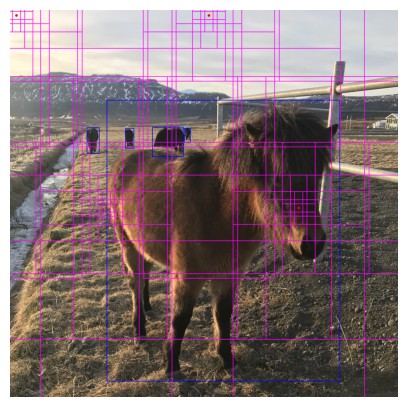

In [208]:
anchors_image = cv2.resize(annotated_image, target_size)

corners_anchors = convert_to_corners(anchors).astype(int)
for i, (anchor, corner_anchor) in enumerate(zip(anchors, corners_anchors)):
    # only display a subset of the anchors
    if i % 225 == 0:
        x1,y1,x2,y2 = corner_anchor.astype(int)
        anchors_image = cv2.rectangle(anchors_image, (x1,y1), (x2,y2), color=(255, 0, 255), thickness=4)
        
        x, y, w, h = anchor
        anchors_image = cv2.circle(anchors_image, (int(x),int(y)), radius=10, color=(255, 0, 0), thickness=-1)  
    
draw_image(anchors_image)